In [ ]:
import rfnetwork as rfn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl 

mpl.rc("legend", loc="lower right")

# 50 ohm ms line on RO4350B substrate
msline50 = rfn.elements.MSLine(
    w=0.043, 
    h=0.020, 
    er=[3.758, 3.73, 3.722], 
    loss=[0.03, 0.142, 0.266],
    frequency=[1e9, 5e9, 10e9]
)

# 70 ohm ms line on RO4350B substrate
msline70p7 = rfn.elements.MSLine(
    w=0.023, 
    h=0.020, 
    er=3.73, 
    loss=0.152,
)

# 35 ohm ms line on RO4350B substrate
msline35= rfn.elements.MSLine(
    w=0.072, 
    h=0.020, 
    er=3.73, 
    loss=0.1,
)

design_fhz = 5e9
# frequency vector for plots
frequency = np.arange(1e9, 9e9, 10e6)

## get quarter wavelength at the design freq
len_qw_50 = msline50.get_wavelength(design_fhz) / 4
len_qw_70p7 = msline70p7.get_wavelength(design_fhz) / 4
len_qw_35 = msline35.get_wavelength(design_fhz) / 4


ldarray([0.35751931])
Coordinates: (1,)
  frequency: [5.e+09]

## Wilkinson Combiner

3-port combiner network

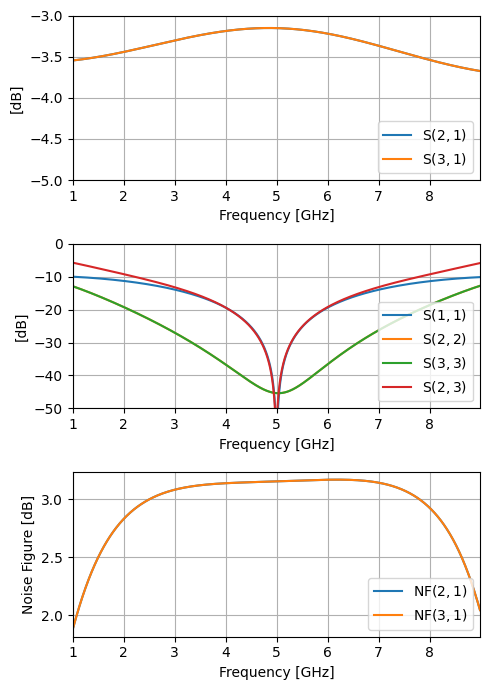

In [5]:
class Wilkinson(rfn.Network):
    """
                 --- upper ----- port 2
                 |           |
       port 1 ----           r1
                 |           |
                 --- lower ----- port 3
    """
    # create line instances with specific length in inches
    upper = msline70p7(len_qw_70p7)
    lower = msline70p7(len_qw_70p7)
    
    r1 = rfn.elements.Resistor(100)

    p1 = msline50(.3)
    p2 = msline50(.3)
    p3 = msline50(.3)

    nodes = [
        ("P1", p1|1),
        ("P2", p2|2),
        ("P3", p3|2),
        (p1|2, upper|1, lower|1),
        (upper|2, r1|1, p2|1),
        (lower|2, r1|2, p3|1)
    ]

w = Wilkinson()

# plot thru paths
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(5, 7))
w.plot(21, 31, fmt="db", frequency=frequency, axes=ax1)
ax1.set_ylim([-5, -3])

# plot isolation and return loss
w.plot(11, 22, 33, 23, fmt="db", frequency=frequency, axes=ax2)
ax2.set_ylim([-50, 0])

# plot passive noise figure
w.plot(21, 31, fmt="nf", frequency=frequency, axes=ax3)

fig.tight_layout()

## Branchline 90 degree Hybrid

4-port hybrid network

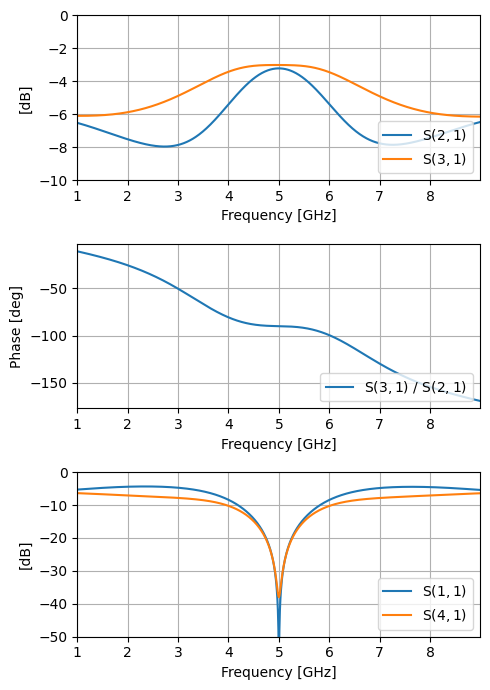

In [6]:

class BranchCoupler(rfn.Network):
    """
      port 1 --------- top ---------- port 2
                 |                |
                left            right
                 |                |
      port 4 ----------btm ---------- port 3
    """

    top = msline35(len_qw_35)
    btm = msline35(len_qw_35)
    
    left = msline50(len_qw_50)
    right = msline50(len_qw_50)

    nodes = [
        # top left corner, port1
        (top|1, left|1, "P1"),
        # top right corner, port2
        (top|2, right|1, "P2"),
        # bottom corner, port 3
        (btm|2, right|2, "P3"),
        # bottom left, port 4
        (btm|1, left|2, "P4"),
    ]

b = BranchCoupler(passive=True)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(5, 7))

# plot thru paths
b.plot(21, 31, fmt="db", frequency=frequency, axes=ax1)
ax1.set_ylim([-10, 0])

# plot phase angle
b.plot(31, ref=21, fmt="ang_unwrap", frequency=frequency, axes=ax2)

# plot isolation and return loss
b.plot(11, 41, fmt="db", frequency=frequency, axes=ax3)
ax3.set_ylim([-50, 0])

fig.tight_layout()